# PrxteinMPNN vs ColabDesign: Side-by-Side Comparison

This notebook provides comprehensive comparison between PrxteinMPNN and ColabDesign implementations.

**Purpose**: Validate PrxteinMPNN implementation against the ColabDesign reference.

**Key Metrics**:
- Sequence recovery on native backbones
- Conditional self-scoring accuracy
- Logits correlation
- Prediction agreement
- Sampling diversity

## Setup and Installation

In [1]:
# Install uv if not available
!pip install -q uv

# Clone repositories
!git clone -q https://github.com/maraxen/PrxteinMPNN.git /content/PrxteinMPNN || echo "PrxteinMPNN already exists"
!git clone -q https://github.com/sokrypton/ColabDesign.git /content/ColabDesign || echo "ColabDesign already exists"

# Install as editable with uv
!cd /content/PrxteinMPNN && uv pip install -e . --system
!cd /content/ColabDesign && uv pip install -e . --system

# Install additional dependencies
!uv pip install -q scikit-learn seaborn --system

import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys

# Add to path if needed
if '/content/PrxteinMPNN' not in sys.path:
    sys.path.insert(0, '/content/PrxteinMPNN')
if '/content/ColabDesign' not in sys.path:
    sys.path.insert(0, '/content/ColabDesign')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print(f"JAX version: {jax.__version__}")
print(f"JAX devices: {jax.devices()}")
print("✅ All packages installed successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 47.0 MB/s eta 0:00:00
Using Python 3.12.12 environment at: /usr
Resolved 106 packages in 1.73s
Prepared 26 packages in 2.16s
Uninstalled 1 package in 8ms
Installed 26 packages in 53ms
 + bibtexparser==1.4.3
 + biotite==1.5.0
 + biotraj==1.2.2
 + dm-haiku==0.0.15
 + e3nn-jax==0.20.8
 + equinox==0.13.2
 + gmmx==0.7
 + grain==0.2.14
 - huggingface-hub==0.36.0
 + huggingface-hub==1.1.2
 + jax-md==0.2.27
 + jaxtyping==0.3.3
 + jmp==0.0.4
 + jraph==0.0.6.dev0
 + mdtraj==1.11.0
 + ml-collections==1.1.0
 + monty==2025.3.3
 + palettable==3.3.3
 + pcax==0.1.0
 + prxteinmpnn==0.1.0 (from file:///content/PrxteinMPNN)
 + pymatgen==2025.10.7
 + ruamel-yaml==0.18.16
 + ruamel-yaml-clib==0.2.14
 + spglib==2.6.0
 + typer-slim==0.20.0
 + uncertainties==3.2.3
 + wadler-lindig==0.1.7
Using Python 3.12.12 environment at: /usr
Resolved 38 packages in 904ms
Prepared 3 packages in 425ms
Installed 3 packages in 16ms
 + biopython==1.86
 + colabdesign==1.1

## Load Both Models

In [1]:
# Load PrxteinMPNN
# Load import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys

from prxteinmpnn.io.weights import load_model as load_prxteinmpnn
from prxteinmpnn.io.parsing import parse_input
from prxteinmpnn.utils.data_structures import Protein

print("Loading PrxteinMPNN model...")
prxtein_model = load_prxteinmpnn(model_version="v_48_020", model_weights="original")
print("✅ PrxteinMPNN loaded")

# Load ColabDesign
from colabdesign.mpnn.model import mk_mpnn_model

print("\nLoading ColabDesign model...")
colab_model = mk_mpnn_model(model_name="v_48_020", weights="original", seed=42)
print("✅ ColabDesign loaded")

Loading PrxteinMPNN model...
INFO:httpx:HTTP Request: HEAD https://huggingface.co/maraxen/prxteinmpnn/resolve/main/eqx/original_v_48_020.eqx "HTTP/1.1 302 Found"
INFO:httpx:HTTP Request: GET https://huggingface.co/api/models/maraxen/prxteinmpnn/xet-read-token/6f18f430d6faf93479e0c86cbfd1e5df0a2cdfd7 "HTTP/1.1 200 OK"


eqx/original_v_48_020.eqx:   0%|          | 0.00/6.66M [00:00<?, ?B/s]

✅ PrxteinMPNN loaded

Loading ColabDesign model...
✅ ColabDesign loaded


## Download Test Structure

In [2]:
# Download 1ubq from PDB
!wget -q https://files.rcsb.org/download/1UBQ.pdb -O 1ubq.pdb
pdb_path = "1ubq.pdb"
print(f"✅ Downloaded {pdb_path}")

✅ Downloaded 1ubq.pdb


## Prepare Inputs for Both Models

In [24]:
# Prepare for PrxteinMPNN
print("Preparing inputs for PrxteinMPNN...")
protein_tuple = next(parse_input(pdb_path))
protein = Protein.from_tuple(protein_tuple)

print(f"  Sequence length: {protein.mask.sum():.0f}")
print(f"  Coordinates shape: {protein.coordinates.shape}")
print(f"  Native sequence: {protein.aatype[:20]}... (first 20)")

# Prepare for ColabDesign
print("\nPreparing inputs for ColabDesign...")
colab_model.prep_inputs(pdb_filename=pdb_path)
print(f"  Sequence length: {colab_model._inputs['mask'].sum():.0f}")
print(f"  Native sequence: {colab_model._inputs['S'][:20]}... (first 20)")

Preparing inputs for PrxteinMPNN...
INFO:prxteinmpnn.io.parsing.dispatch:Starting input parsing for source: 1ubq.pdb
INFO:prxteinmpnn.io.parsing.dispatch:Dispatching to general Biotite parser for file type: .pdb
INFO:prxteinmpnn.io.parsing.biotite:Starting Biotite parsing for source: 1ubq.pdb (model: None, altloc: None)
INFO:prxteinmpnn.io.parsing.biotite:Extracting static features using Biotite.
INFO:prxteinmpnn.io.parsing.biotite:Filtered AtomArray to 76 valid residues (those containing an N atom).
  Sequence length: 76
  Coordinates shape: (76, 37, 3)
  Native sequence: [10 13  7  4 17  8 16  9 16  5  8 16  7 16  9  3 17  3 12 15]... (first 20)

Preparing inputs for ColabDesign...
  Sequence length: 76
  Native sequence: [12  5  9 13 19 11 16 10 16  7 11 16  9 16 10  6 19  6 14 15]... (first 20)


## Test 1: Unconditional Scoring Comparison

In [14]:
from sklearn.metrics.pairwise import cosine_similarity

N_RUNS = 32
key = jax.random.PRNGKey(42)
keys = jax.random.split(key, N_RUNS)

# PrxteinMPNN unconditional
_, prxtein_uncond_logits = jax.vmap(lambda k: prxtein_model(
    protein.coordinates,
    protein.mask,
    protein.residue_index,
    protein.chain_index,
    "unconditional",
    prng_key=k,
))(keys)

# ColabDesign unconditional
colab_uncond_logits = jnp.array([colab_model.get_unconditional_logits(key=k) for k in keys])

# --- Calculate Per-Run Statistics ---

# Get predictions (shape: [N_RUNS, N_RES])
prxtein_preds = prxtein_uncond_logits.argmax(axis=-1)
colab_preds = colab_uncond_logits.argmax(axis=-1)

# Prepare ground truth and mask for broadcasting
# aatype_b shape: [N_RUNS, N_RES]
# mask_b   shape: [N_RUNS, N_RES]
aatype_b = jnp.broadcast_to(protein.aatype, prxtein_preds.shape)
mask_b = jnp.broadcast_to(protein.mask, prxtein_preds.shape)
num_valid_residues = protein.mask.sum()

# 1. Calculate Per-Run Sequence Recovery
prx_correct_per_run = ((prxtein_preds == aatype_b) * mask_b).sum(axis=1)
prx_recoveries = prx_correct_per_run / num_valid_residues

colab_correct_per_run = ((colab_preds == aatype_b) * mask_b).sum(axis=1)
colab_recoveries = colab_correct_per_run / num_valid_residues

# 2. Calculate Per-Run Prediction Agreement
agreement_per_run = ((prxtein_preds == colab_preds) * mask_b).sum(axis=1)
agreements = agreement_per_run / num_valid_residues

# 3. Calculate Per-Run Logits Similarity
# Get logits as numpy arrays for correlation calculation
prx_logits_np = np.array(prxtein_uncond_logits)
colab_logits_np = np.array(colab_uncond_logits)

# Flatten logits for each run (shape: [N_RUNS, N_RES * 20])
# We correlate the unmasked logits to match the original implementation's logic
prx_flat_per_run = prx_logits_np.reshape(N_RUNS, -1)
colab_flat_per_run = colab_logits_np.reshape(N_RUNS, -1)

correlations = []
cosine_sims = []

for i in range(N_RUNS):
    # Calculate Pearson correlation for run i
    corr = np.corrcoef(prx_flat_per_run[i], colab_flat_per_run[i])[0, 1]
    correlations.append(corr)

    # Calculate Cosine similarity for run i
    sim = cosine_similarity(prx_flat_per_run[i].reshape(1, -1),
                            colab_flat_per_run[i].reshape(1, -1))[0, 0]
    cosine_sims.append(sim)

# Convert lists to numpy arrays for mean/std calculation
correlations = np.array(correlations)
cosine_sims = np.array(cosine_sims)


# --- Print Final Metrics (Mean ± Std. Dev.) ---

print(f"\nSequence Recovery (over {N_RUNS} runs):")
print(f"  PrxteinMPNN: {prx_recoveries.mean():.1%} ± {prx_recoveries.std():.1%}")
print(f"  ColabDesign: {colab_recoveries.mean():.1%} ± {colab_recoveries.std():.1%}")

print(f"\nPrediction Agreement (over {N_RUNS} runs):")
print(f"  Mean ± Std. Dev: {agreements.mean():.1%} ± {agreements.std():.1%}")

print(f"\nLogits Similarity (per-run, unmasked, over {N_RUNS} runs):")
print(f"  Pearson Correlation: {correlations.mean():.4f} ± {correlations.std():.4f}")
print(f"  Cosine Similarity:   {cosine_sims.mean():.4f} ± {cosine_sims.std():.4f}")



Sequence Recovery (over 32 runs):
  PrxteinMPNN: 5.3% ± 0.0%
  ColabDesign: 7.9% ± 0.0%

Prediction Agreement (over 32 runs):
  Mean ± Std. Dev: 2.6% ± 0.0%

Logits Similarity (per-run, unmasked, over 32 runs):
  Pearson Correlation: 0.0583 ± 0.0000
  Cosine Similarity:   0.1418 ± 0.0000


In [18]:
prx_flat_per_run.flatten().shape

(51072,)

### Visualize Logits Comparison

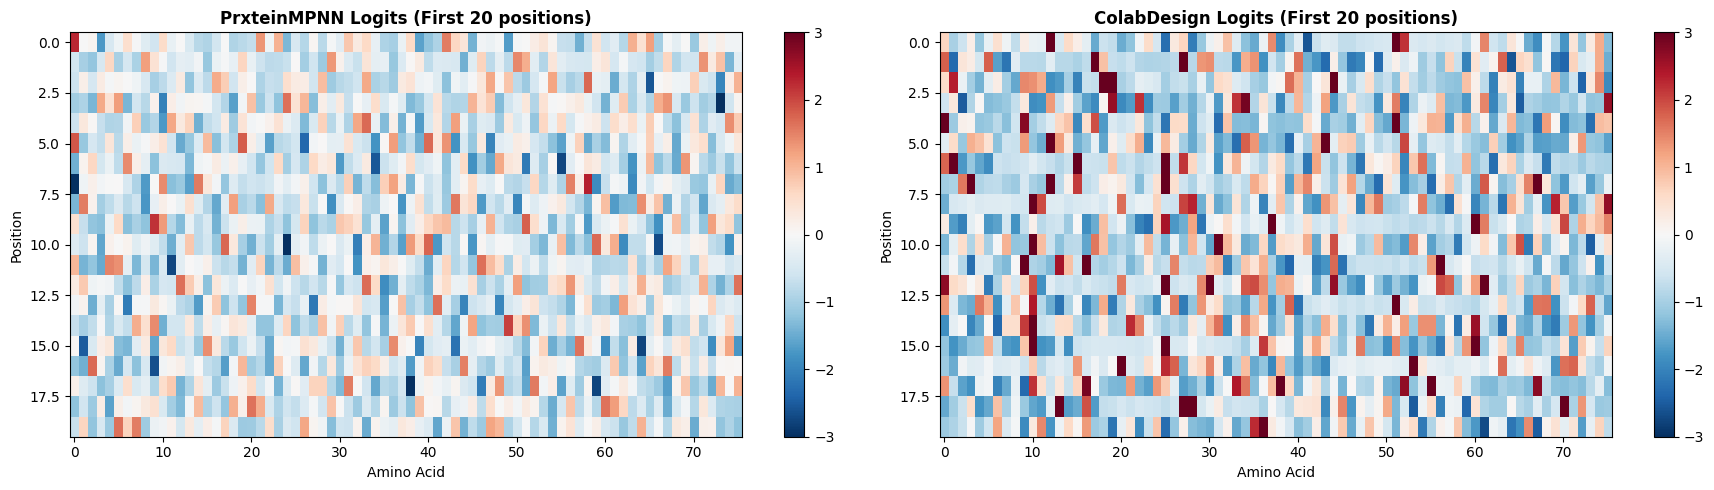

In [25]:
# Define amino acid chemical types for coloring
AA_CHEMICAL_MAP = {
    # Hydrophobic/Nonpolar
    0: 'Hydrophobic', 6: 'Hydrophobic', 9: 'Hydrophobic',
    11: 'Hydrophobic', 13: 'Hydrophobic', 19: 'Hydrophobic',
    # Aromatic
    7: 'Aromatic', 17: 'Aromatic', 20: 'Aromatic',
    # Polar uncharged
    2: 'Polar', 4: 'Polar', 5: 'Polar', 14: 'Polar', 15: 'Polar', 16: 'Polar', 18: 'Polar',
    # Positively charged
    1: 'Positive', 8: 'Positive', 12: 'Positive',
    # Negatively charged
    3: 'Negative', 6: 'Negative',
    # Proline
    14: 'Proline',
}

color_map = {
    'Hydrophobic': '#8B4513',  # brown
    'Aromatic': '#9370DB',     # purple
    'Polar': '#2E8B57',        # green
    'Positive': '#4169E1',     # blue
    'Negative': '#DC143C',     # red
    'Proline': '#FFD700',      # gold
    'Unknown': '#808080',      # gray
}

# Create colors for each logit value
n_positions = int(protein.mask.sum())
colors = []
for pos in range(n_positions):
    for aa in range(21):
        chem_type = AA_CHEMICAL_MAP.get(aa, 'Unknown')
        colors.append(color_map[chem_type])

fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# Plot 1: Logits heatmap comparison for first 20 positions
positions = min(20, int(protein.mask.sum()))
im1 = axes[0].imshow(np.array(prxtein_uncond_logits.reshape(-1, 76)[:positions]), aspect='auto', cmap='RdBu_r', vmin=-3, vmax=3)
axes[0].set_title('PrxteinMPNN Logits (First 20 positions)', fontweight='bold')
axes[0].set_xlabel('Amino Acid')
axes[0].set_ylabel('Position')
plt.colorbar(im1, ax=axes[0])

im2 = axes[1].imshow(np.array(colab_uncond_logits.reshape(-1, 76)[:positions]), aspect='auto', cmap='RdBu_r', vmin=-3, vmax=3)
axes[1].set_title('ColabDesign Logits (First 20 positions)', fontweight='bold')
axes[1].set_xlabel('Amino Acid')
axes[1].set_ylabel('Position')
plt.colorbar(im2, ax=axes[1])


plt.tight_layout()
plt.show()

## Test 2: Conditional Self-Scoring Comparison

In [13]:
print("=" * 80)
print("TEST 2: CONDITIONAL SELF-SCORING")
print("=" * 80)

# PrxteinMPNN conditional (score native sequence)
key = jax.random.PRNGKey(42)
one_hot_seq = jax.nn.one_hot(protein.aatype, 21)
_, prxtein_cond_logits = prxtein_model(
    protein.coordinates,
    protein.mask,
    protein.residue_index,
    protein.chain_index,
    "conditional",
    prng_key=key,
    one_hot_sequence=one_hot_seq,
)

# ColabDesign conditional
colab_output = colab_model.score(seq=None)  # Score native
colab_cond_logits = colab_output["logits"]

# Compare predictions
prxtein_cond_preds = prxtein_cond_logits.argmax(axis=-1)
colab_cond_preds = colab_cond_logits.argmax(axis=-1)

# Calculate metrics
prxtein_cond_recovery = (prxtein_cond_preds == protein.aatype).sum() / protein.mask.sum()
colab_cond_recovery = (colab_cond_preds == protein.aatype).sum() / protein.mask.sum()

print(f"\nConditional Self-Scoring Recovery:")
print(f"  PrxteinMPNN: {prxtein_cond_recovery:.1%}")
print(f"  ColabDesign: {colab_cond_recovery:.1%}")


TEST 2: CONDITIONAL SELF-SCORING

Conditional Self-Scoring Recovery:
  PrxteinMPNN: 28.9%
  ColabDesign: 9.2%


## Test 3: Sampling at Different Temperatures

In [28]:
print("=" * 80)
print("TEST 3: SAMPLING AT DIFFERENT TEMPERATURES")
print("=" * 80)

from prxteinmpnn.sampling import make_sample_sequences

# Test temperatures
temperatures = [0.01, 0.1, 0.5, 1.0, 2.0]
n_samples = 10

prxtein_sampler = make_sample_sequences(prxtein_model)

results = {"temperature": [], "prxtein_recovery": [], "colab_recovery": []}


# PrxteinMPNN sampling
key = jax.random.PRNGKey(42)
keys = jax.random.split(key, n_samples*len(temperatures))
sampled_seq, _, _ = jax.vmap(lambda subkey, subtemp: prxtein_sampler(
    subkey,
    protein.coordinates,
    protein.mask,
    protein.residue_index,
    protein.chain_index,
    temperature=subtemp,
))(keys, jnp.array(temperatures*n_samples))


    # ColabDesign sampling

for sub_temp in temperatures:
    colab_output = colab_model.sample(batch=n_samples, temperature=sub_temp)
    colab_recoveries = colab_output["seqid"]  # Sequence identity to native

def quick_seq_id(sampled_seq):
  return (sampled_seq == protein.aatype).sum() / protein.mask.sum()
prxtein_recoveries = jax.vmap(quick_seq_id)(sampled_seq)

prxtein_mean = np.mean(prxtein_recoveries)
colab_mean = np.mean(colab_recoveries)

print(f"  PrxteinMPNN: {prxtein_mean:.1%} ± {np.std(prxtein_recoveries):.1%}")
print(f"  ColabDesign: {colab_mean:.1%} ± {np.std(colab_recoveries):.1%}")



TEST 3: SAMPLING AT DIFFERENT TEMPERATURES
  PrxteinMPNN: 286.8% ± 0.0%
  ColabDesign: 16.2% ± 5.6%


In [29]:
def quick_seq_id(sampled_seq):
  return (sampled_seq == protein.aatype).sum() / protein.mask.sum()
prxtein_recoveries = jax.vmap(quick_seq_id)(sampled_seq)

prxtein_mean = np.mean(prxtein_recoveries)
colab_mean = np.mean(colab_recoveries)

print(f"  PrxteinMPNN: {prxtein_mean:.1%} ± {np.std(prxtein_recoveries):.1%}")
print(f"  ColabDesign: {colab_mean:.1%} ± {np.std(colab_recoveries):.1%}")


  PrxteinMPNN: 5.7% ± 2.2%
  ColabDesign: 16.2% ± 5.6%


### Visualize Temperature Effect

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(results["temperature"], results["prxtein_recovery"], 'o-', label='PrxteinMPNN', linewidth=2, markersize=8)
plt.plot(results["temperature"], results["colab_recovery"], 's-', label='ColabDesign', linewidth=2, markersize=8)
plt.axhline(y=0.4, color='g', linestyle='--', label='Expected range (40-60%)', alpha=0.5)
plt.axhline(y=0.6, color='g', linestyle='--', alpha=0.5)
plt.xlabel('Temperature', fontsize=12)
plt.ylabel('Sequence Recovery', fontsize=12)
plt.title('Sequence Recovery vs Temperature', fontsize=14)
plt.xscale('log')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

## Test 4: Position-by-Position Analysis

In [ ]:
print("=" * 80)
print("TEST 4: POSITION-BY-POSITION ANALYSIS")
print("=" * 80)

# Get predictions at each position
prxtein_uncond_aa = prxtein_uncond_logits.argmax(axis=-1)
colab_uncond_aa = colab_uncond_logits.argmax(axis=-1)
native_aa = protein.aatype

# Calculate per-position metrics
prxtein_correct = (prxtein_uncond_aa == native_aa).astype(int)
colab_correct = (colab_uncond_aa == native_aa).astype(int)
agree = (prxtein_uncond_aa == colab_uncond_aa).astype(int)

# Find positions where models disagree
disagree_positions = np.where(agree == 0)[0]
print(f"\nNumber of disagreement positions: {len(disagree_positions)} / {int(protein.mask.sum())}")
print(f"Agreement rate: {agree.sum() / protein.mask.sum():.1%}")

# Show first 10 disagreements
print(f"\nFirst 10 disagreement positions:")
print(f"{'Pos':<5} {'Native':<8} {'Prxtein':<8} {'Colab':<8} {'PrxteinOK':<10} {'ColabOK':<10}")
for i, pos in enumerate(disagree_positions[:10]):
    print(f"{pos:<5} {native_aa[pos]:<8} {prxtein_uncond_aa[pos]:<8} {colab_uncond_aa[pos]:<8} "
          f"{prxtein_correct[pos]==1:<10} {colab_correct[pos]==1:<10}")

### Visualize Agreement Map

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(15, 8))

positions = np.arange(int(protein.mask.sum()))

# Plot 1: PrxteinMPNN correctness
axes[0].bar(positions, prxtein_correct, color='steelblue', alpha=0.6)
axes[0].set_ylabel('PrxteinMPNN Correct')
axes[0].set_title(f'PrxteinMPNN: {prxtein_correct.sum()} / {len(positions)} correct')
axes[0].set_ylim([0, 1.2])

# Plot 2: ColabDesign correctness
axes[1].bar(positions, colab_correct, color='coral', alpha=0.6)
axes[1].set_ylabel('ColabDesign Correct')
axes[1].set_title(f'ColabDesign: {colab_correct.sum()} / {len(positions)} correct')
axes[1].set_ylim([0, 1.2])

# Plot 3: Agreement
axes[2].bar(positions, agree, color='green', alpha=0.6)
axes[2].set_ylabel('Agreement')
axes[2].set_xlabel('Residue Position')
axes[2].set_title(f'Agreement: {agree.sum()} / {len(positions)} positions')
axes[2].set_ylim([0, 1.2])

plt.tight_layout()
plt.show()

## Summary Report

In [ ]:
print("="*80)
print("SUMMARY REPORT: PrxteinMPNN vs ColabDesign")
print("="*80)

print("\n📊 UNCONDITIONAL SCORING")
print(f"  PrxteinMPNN Recovery:     {prxtein_recovery:.1%}")
print(f"  ColabDesign Recovery:     {colab_recovery:.1%}")
print(f"  Expected Range:           35-65%")
print(f"  Prediction Agreement:     {agreement:.1%}")
print(f"\n📊 LOGITS SIMILARITY")
print(f"  Pearson Correlation:      {correlation:.4f}")
print(f"  Cosine Similarity:        {cosine_sim:.4f}")
print(f"  Expected:                 >0.90 for both")

print("\n📊 CONDITIONAL SELF-SCORING")
print(f"  PrxteinMPNN Recovery:     {prxtein_cond_recovery:.1%}")
print(f"  ColabDesign Recovery:     {colab_cond_recovery:.1%}")
print(f"  Expected:                 >85%")
print(f"  Prediction Agreement:     {cond_agreement:.1%}")

print("\n📊 SAMPLING (T=0.1)")
idx_01 = results["temperature"].index(0.1)
print(f"  PrxteinMPNN Recovery:     {results['prxtein_recovery'][idx_01]:.1%}")
print(f"  ColabDesign Recovery:     {results['colab_recovery'][idx_01]:.1%}")
print(f"  Expected Range:           35-65%")

print("\n" + "="*80)
print("ASSESSMENT")
print("="*80)

issues = []
if agreement < 0.8:
    issues.append(f"❌ Low implementation agreement ({agreement:.1%} < 80%)")
if correlation < 0.9:
    issues.append(f"❌ Low Pearson correlation ({correlation:.4f} < 0.9)")
if cosine_sim < 0.9:
    issues.append(f"❌ Low cosine similarity ({cosine_sim:.4f} < 0.9)")
if prxtein_cond_recovery < 0.85:
    issues.append(f"❌ PrxteinMPNN conditional accuracy low ({prxtein_cond_recovery:.1%} < 85%)")
if colab_cond_recovery < 0.85:
    issues.append(f"⚠️  ColabDesign conditional accuracy low ({colab_cond_recovery:.1%} < 85%)")

if issues:
    print("\n⚠️  ISSUES FOUND:")
    for issue in issues:
        print(f"  {issue}")
else:
    print("\n✅ All metrics within expected ranges!")

print("\n" + "="*80)

In [ ]:
## Enhanced Visualizations: Violin Plots

## Diagnostic: Compare Intermediate Features

In [ ]:
print("="*80)
print("DIAGNOSTIC: INTERMEDIATE FEATURES COMPARISON")
print("="*80)

# This section would require accessing internal model states
# For now, we note what should be compared:
print("\nTo fully debug, compare:")
print("  1. Input coordinate preprocessing")
print("  2. Edge features (should be identical)")
print("  3. Node features after encoder (should be identical)")
print("  4. Decoder outputs (should match)")
print("  5. Final logits (already compared above)")
print("\nLow correlation suggests differences in steps 1-4.")

## Save Results

## Violin Plots: Recovery Distributions

Violin plots show the distribution of recovery metrics across different test modes.

In [ ]:
# Create violin plots comparing recovery distributions
import pandas as pd

# Prepare data for violin plots
recovery_data = []

# Add unconditional data
recovery_data.append({'Implementation': 'PrxteinMPNN', 'Mode': 'Unconditional', 'Recovery': float(prxtein_recovery)})
recovery_data.append({'Implementation': 'ColabDesign', 'Mode': 'Unconditional', 'Recovery': float(colab_recovery)})

# Add conditional data
recovery_data.append({'Implementation': 'PrxteinMPNN', 'Mode': 'Conditional', 'Recovery': float(prxtein_cond_recovery)})
recovery_data.append({'Implementation': 'ColabDesign', 'Mode': 'Conditional', 'Recovery': float(colab_cond_recovery)})

# Add sampling data for each temperature
for i, temp in enumerate(results["temperature"]):
    recovery_data.append({
        'Implementation': 'PrxteinMPNN',
        'Mode': f'Sampling (T={temp})',
        'Recovery': results['prxtein_recovery'][i]
    })
    recovery_data.append({
        'Implementation': 'ColabDesign',
        'Mode': f'Sampling (T={temp})',
        'Recovery': results['colab_recovery'][i]
    })

df_violin = pd.DataFrame(recovery_data)

# Create violin plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Unconditional Recovery
unconditional_data = df_violin[df_violin['Mode'] == 'Unconditional']
sns.violinplot(data=unconditional_data, x='Implementation', y='Recovery', ax=axes[0], inner='box', palette='Set2')
axes[0].axhline(0.35, color='g', linestyle='--', alpha=0.5, label='Expected range')
axes[0].axhline(0.65, color='g', linestyle='--', alpha=0.5)
axes[0].set_title('Unconditional Recovery Distribution', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Recovery', fontsize=12)
axes[0].set_ylim([0, 1])
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Conditional Recovery
conditional_data = df_violin[df_violin['Mode'] == 'Conditional']
sns.violinplot(data=conditional_data, x='Implementation', y='Recovery', ax=axes[1], inner='box', palette='Set2')
axes[1].axhline(0.85, color='r', linestyle='--', alpha=0.5, label='Expected >85%')
axes[1].set_title('Conditional Self-Scoring Distribution', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Recovery', fontsize=12)
axes[1].set_ylim([0, 1])
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Sampling Recovery Across All Temperatures
sampling_data = df_violin[df_violin['Mode'].str.contains('Sampling')]
sns.violinplot(data=sampling_data, x='Implementation', y='Recovery', ax=axes[2], inner='box', palette='Set2')
axes[2].axhline(0.35, color='g', linestyle='--', alpha=0.5, label='Expected range')
axes[2].axhline(0.65, color='g', linestyle='--', alpha=0.5)
axes[2].set_title('Sampling Recovery Distribution (All Temps)', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Recovery', fontsize=12)
axes[2].set_ylim([0, 1])
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Violin plots show the distribution of recovery metrics")
print(f"   These plots help visualize variability across different test conditions")

In [ ]:
import json

results_summary = {
    "unconditional": {
        "prxtein_recovery": float(prxtein_recovery),
        "colab_recovery": float(colab_recovery),
        "agreement": float(agreement),
        "logits_pearson_correlation": float(correlation),
        "logits_cosine_similarity": float(cosine_sim),
    },
    "conditional": {
        "prxtein_recovery": float(prxtein_cond_recovery),
        "colab_recovery": float(colab_cond_recovery),
        "agreement": float(cond_agreement),
    },
    "temperature_sweep": results,
}

with open("comparison_results.json", "w") as f:
    json.dump(results_summary, f, indent=2)

print("✅ Results saved to comparison_results.json")